In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

#necessary imports for data analysis and ML

# Importing and reading data

<p>Fom kaggle : "This dataset contains air quality data from the national capital of Delhi, India. It includes information on air pollution levels, including particulate matter (PM2.5 and PM10) levels, nitrogen dioxide (NO2), sulfur dioxide (SO2), carbon dioxide (CO2), ozone (O3), and other pollutants. The data was collected from monitoring stations located in various areas of Delhi between November 25, 2020, and January 24, 2023. This dataset is a valuable resource for researchers and policymakers to better understand air quality in Delhi and its impacts on public health."</p>

In [2]:
df = pd.read_csv('delhi_aqi.csv')
df.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


### Preliminary analysis:
<p>We see the data has a few columns for each pollutant and one column for the date, we will now check for missing values</p>

In [3]:
#finding the null values across each column
df.isnull().sum()
null_boolean = df.isnull()
null_boolean[(null_boolean.co == True) | (null_boolean.no == True) | (null_boolean.no2 == True) | (null_boolean.o3 == True) | (null_boolean.so2 == True) | (null_boolean.pm2_5 == True) | (null_boolean.pm10 == True) | (null_boolean.nh3 == True)]
#there are no missing value

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3


<p>As clearly seen above, we obtain an empty dataframe, meaning we have no missing values, and can move on to better data analysis</p>

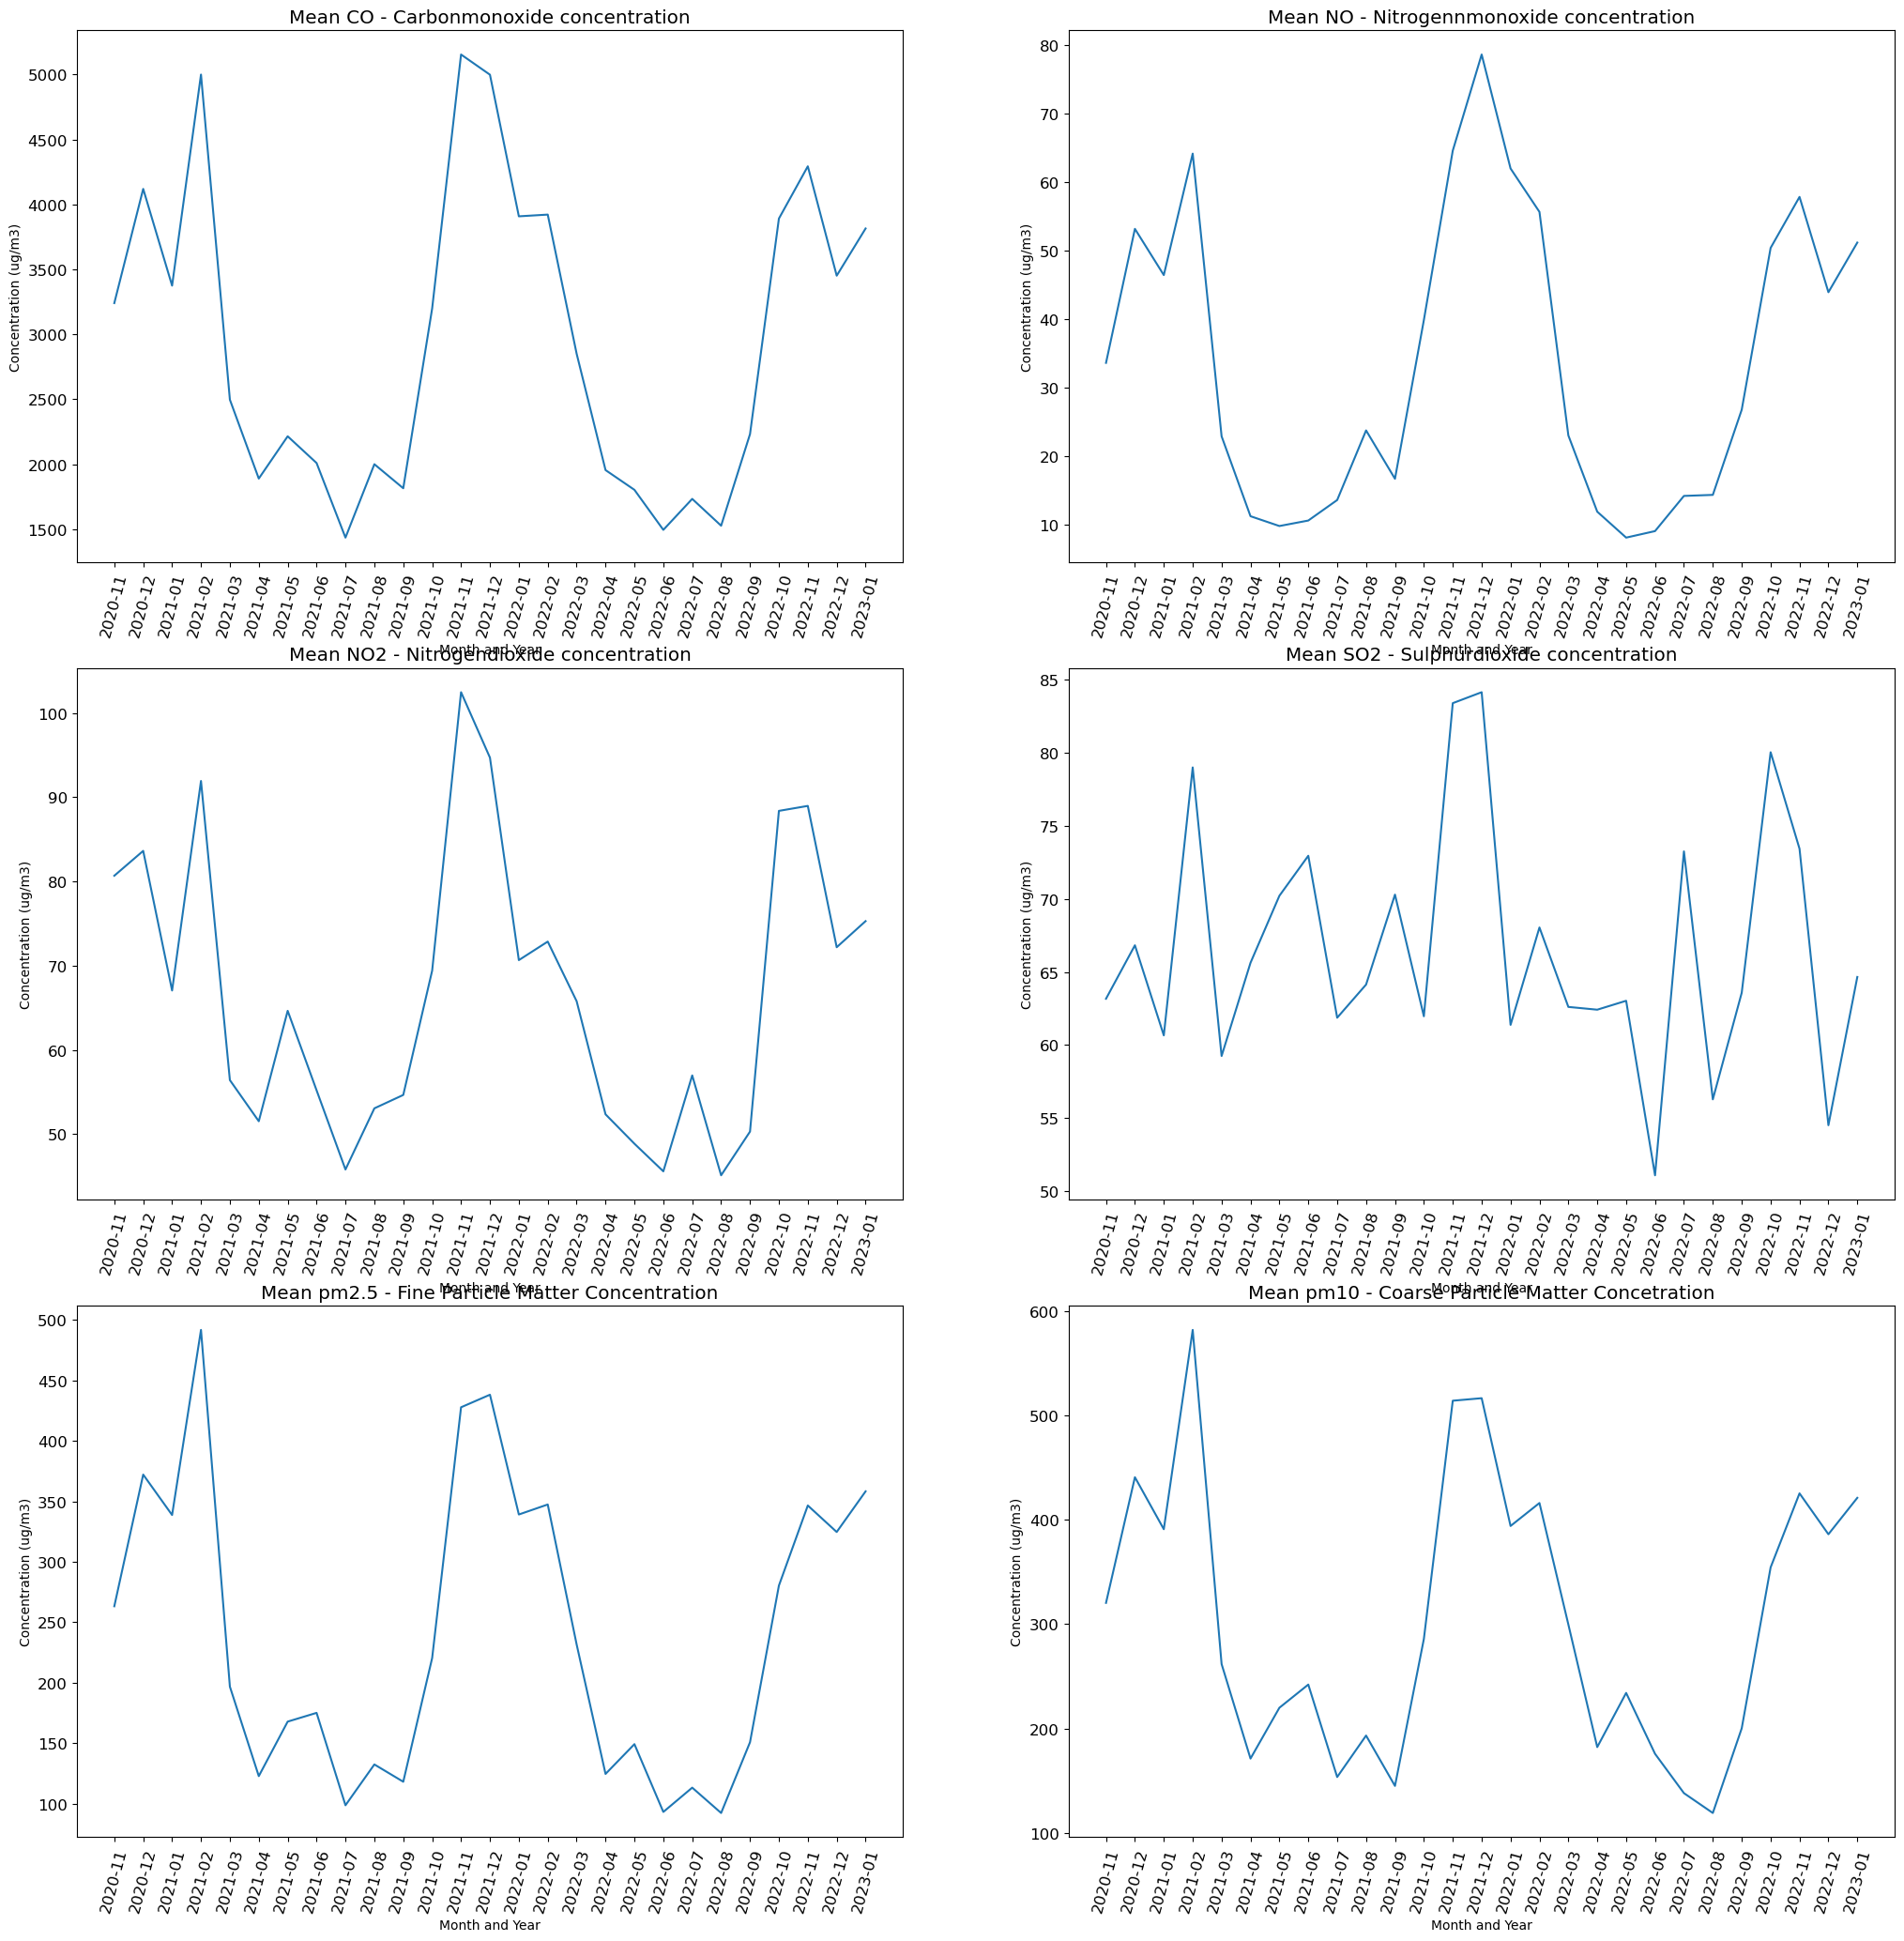

In [4]:
#converting string date type to datetime
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M').astype('str')
df['datetime'] = pd.to_datetime(df['date'])

month_year_analysis = df.groupby('month_year')[['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']].agg(['mean']).round(2).reset_index()

fig, axes = plt.subplots(3,2, figsize=(25,25))

#Carbonmonoxide trend
co_analysis = month_year_analysis[['month_year','co']]
axes[0,0].set_title('Mean CO - Carbonmonoxide concentration')
axes[0,0].set_xlabel('Month and Year', fontsize=10)
axes[0,0].set_ylabel('Concentration (ug/m3)', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=75)
axes[0,0].plot(co_analysis['month_year'], co_analysis['co'])

#Nitrogenmonoxide trend
no_analysis = month_year_analysis[['month_year','no']]
axes[0,1].set_title('Mean NO - Nitrogennmonoxide concentration')
axes[0,1].set_xlabel('Month and Year', fontsize=10)
axes[0,1].set_ylabel('Concentration (ug/m3)', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=75)
axes[0,1].plot(no_analysis['month_year'], no_analysis['no'])

#Nitrogendioxide trend
no2_analysis = month_year_analysis[['month_year','no2']]
axes[1,0].set_title('Mean NO2 - Nitrogendioxide concentration')
axes[1,0].set_xlabel('Month and Year', fontsize=10)
axes[1,0].set_ylabel('Concentration (ug/m3)', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=75)
axes[1,0].plot(no2_analysis['month_year'], no2_analysis['no2'])

#Sulphurdioxide trend 
so2_analysis = month_year_analysis[['month_year','so2']]
axes[1,1].set_title('Mean SO2 - Sulphurdioxide concentration')
axes[1,1].set_xlabel('Month and Year', fontsize=10)
axes[1,1].set_ylabel('Concentration (ug/m3)', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=75)
axes[1,1].plot(so2_analysis['month_year'], so2_analysis['so2'])


#Fine Particle Matter Trend
fine_particle_analysis = month_year_analysis[['month_year','pm2_5']]
axes[2,0].set_title('Mean pm2.5 - Fine Particle Matter Concentration')
axes[2,0].set_xlabel('Month and Year', fontsize=10)
axes[2,0].set_ylabel('Concentration (ug/m3)', fontsize=10)
axes[2,0].tick_params(axis='x', rotation=75)
axes[2,0].plot(fine_particle_analysis['month_year'], fine_particle_analysis['pm2_5'])


#Coarse Particle Matter Trend
coarse_particle_analysis = month_year_analysis[['month_year', 'pm10']]
axes[2,1].set_title('Mean pm10 - Coarse Particle Matter Concetration')
axes[2,1].set_xlabel('Month and Year', fontsize=10)
axes[2,1].set_ylabel('Concentration (ug/m3)', fontsize=10)
axes[2,1].tick_params(axis='x', rotation=75)
axes[2,1].plot(coarse_particle_analysis['month_year'], coarse_particle_analysis['pm10'])

### Trend analysis:
<p>We observe clear trends here when looking at data across time and the evidence of a strong cyclical pattern, timeseries could work well to predict future patterns in this case. We countinues our data analysis by looking at ozone concentration and then mapping its correlation with each pollutant, this will help with feature engineering</p>

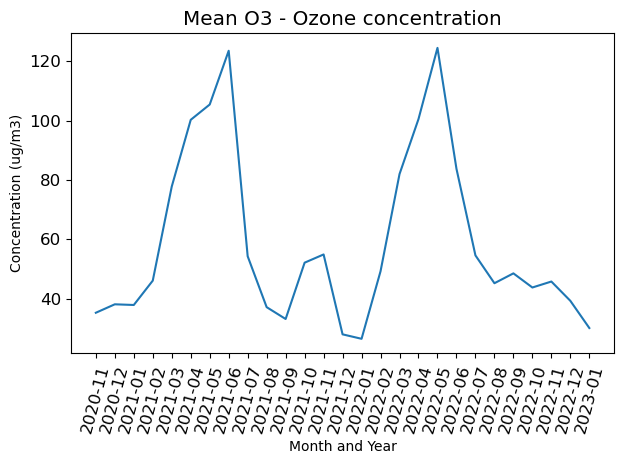

In [5]:
#Ozone trend
o3_analysis = month_year_analysis[['month_year','o3']]
plt.title('Mean O3 - Ozone concentration')
plt.xlabel('Month and Year', fontsize=10)
plt.ylabel('Concentration (ug/m3)', fontsize=10)
plt.xticks(rotation=75)
plt.plot(o3_analysis['month_year'], o3_analysis['o3'])

plt.tight_layout()

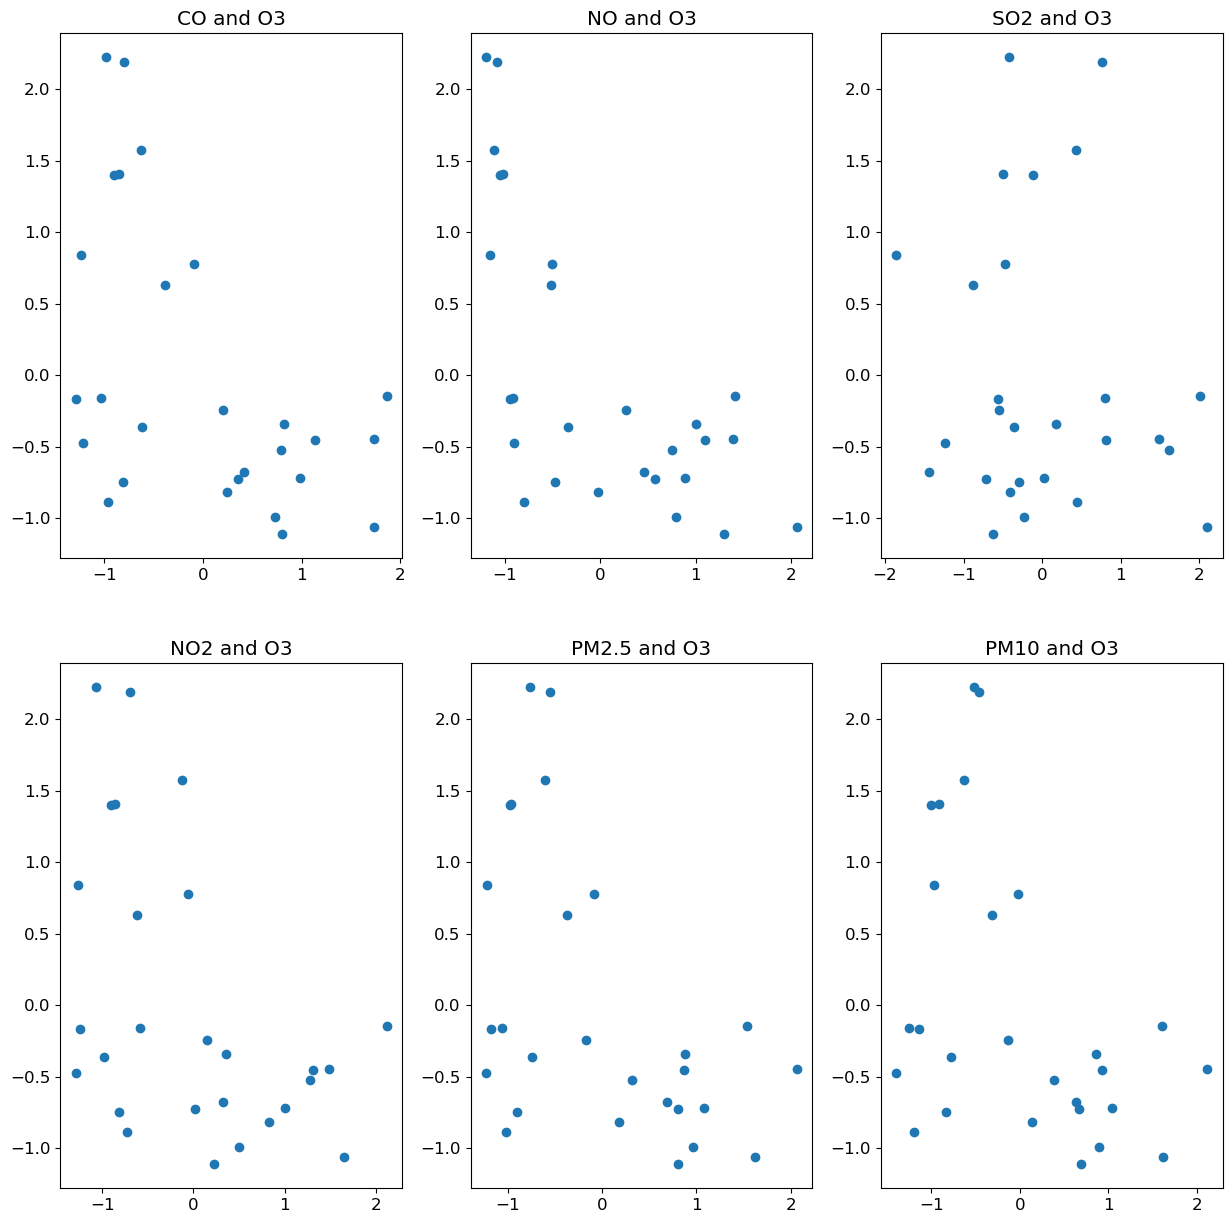

In [6]:
fig, axes = plt.subplots(2,3, figsize=(15,15))

################# CO and O3 Correlation #################
co_standardised = ((co_analysis.co - co_analysis.co.mean())/co_analysis.co.std()).rename(columns={'mean': 'co_mean'})
o3_standardised = ((o3_analysis.o3 - o3_analysis.o3.mean())/o3_analysis.o3.std()).rename(columns={'mean': 'o3_mean'})
axes[0,0].set_title("CO and O3")
axes[0,0].scatter(co_standardised, o3_standardised)
merged_data_co_o3 = pd.merge(co_standardised.reset_index(), o3_standardised.reset_index(), on = 'index')[['co_mean', 'o3_mean']]

################# NO and O3 Correlation #################
no_standardised = ((no_analysis.no - no_analysis.no.mean())/no_analysis.no.std()).rename(columns={'mean': 'no_mean'})
o3_standardised = ((o3_analysis.o3 - o3_analysis.o3.mean())/o3_analysis.o3.std()).rename(columns={'mean': 'o3_mean'})
axes[0,1].set_title("NO and O3")
axes[0,1].scatter(no_standardised, o3_standardised)
merged_data_no_o3 = pd.merge(no_standardised.reset_index(), o3_standardised.reset_index(), on = 'index')[['no_mean', 'o3_mean']]

################# SO2 and O3 Correlation #################
so2_standardised = ((so2_analysis.so2 - so2_analysis.so2.mean())/so2_analysis.so2.std()).rename(columns={'mean': 'so2_mean'})
o3_standardised = ((o3_analysis.o3 - o3_analysis.o3.mean())/o3_analysis.o3.std()).rename(columns={'mean': 'o3_mean'})
axes[0,2].set_title("SO2 and O3")
axes[0,2].scatter(so2_standardised, o3_standardised)
merged_data_so2_o3 = pd.merge(so2_standardised.reset_index(), o3_standardised.reset_index(), on = 'index')[['so2_mean', 'o3_mean']]

################# NO2 and O3 Correlation #################
no2_standardised = ((no2_analysis.no2 - no2_analysis.no2.mean())/no2_analysis.no2.std()).rename(columns={'mean': 'no2_mean'})
o3_standardised = ((o3_analysis.o3 - o3_analysis.o3.mean())/o3_analysis.o3.std()).rename(columns={'mean': 'o3_mean'})
axes[1,0].set_title("NO2 and O3")
axes[1,0].scatter(no2_standardised, o3_standardised)
merged_data_no2_o3 = pd.merge(no2_standardised.reset_index(), o3_standardised.reset_index(), on = 'index')[['no2_mean', 'o3_mean']]

################# PM2.5 and O3 Correlation #################
pm2_5_standardised = ((fine_particle_analysis.pm2_5 - fine_particle_analysis.pm2_5.mean())/fine_particle_analysis.pm2_5.std()).rename(columns={'mean': 'pm2_5_mean'})
o3_standardised = ((o3_analysis.o3 - o3_analysis.o3.mean())/o3_analysis.o3.std()).rename(columns={'mean': 'o3_mean'})
axes[1,1].set_title("PM2.5 and O3")
axes[1,1].scatter(pm2_5_standardised, o3_standardised)
merged_data_pm2_5_o3 = pd.merge(pm2_5_standardised.reset_index(), o3_standardised.reset_index(), on = 'index')[['pm2_5_mean', 'o3_mean']]

################# PM10 and O3 Correlation #################
pm10_standardised = ((coarse_particle_analysis.pm10 - coarse_particle_analysis.pm10.mean())/coarse_particle_analysis.pm10.std()).rename(columns={'mean': 'pm10_mean'})
o3_standardised = ((o3_analysis.o3 - o3_analysis.o3.mean())/o3_analysis.o3.std()).rename(columns={'mean': 'o3_mean'})
axes[1,2].set_title("PM10 and O3")
axes[1,2].scatter(pm10_standardised, o3_standardised)
merged_data_pm10_o3 = pd.merge(pm10_standardised.reset_index(), o3_standardised.reset_index(), on = 'index')[['pm10_mean', 'o3_mean']]

In [7]:
correlation_df = pd.DataFrame([merged_data_co_o3.corr()['co_mean']['o3_mean'], merged_data_no_o3.corr()['no_mean']['o3_mean'], merged_data_so2_o3.corr()['so2_mean']['o3_mean'], merged_data_no2_o3.corr()['no2_mean']['o3_mean'], merged_data_pm2_5_o3.corr()['pm2_5_mean']['o3_mean'], merged_data_pm10_o3.corr()['pm10_mean']['o3_mean']], 
                               index=['CO', 'NO', 'SO2', 'NO2', 'PM2.5', 'PM10'], columns = ['o3_correlation'])
element = correlation_df.index[correlation_df['o3_correlation'] == correlation_df['o3_correlation'].min()]
print(f"The element with the highest effect on ozone layer depletion is {element[0]}")

The element with the highest effect on ozone layer depletion is NO


## Predicting for Carbon Dioxide

We will start by using timeseries to predict the CO2 level

In [8]:
df_CO2 = df[['datetime','co']]
df_CO2.head()

,datetime,co
0,2020-11-25 01:00:00,2616.88
1,2020-11-25 02:00:00,3631.59
2,2020-11-25 03:00:00,4539.49
3,2020-11-25 04:00:00,4539.49
4,2020-11-25 05:00:00,4379.27


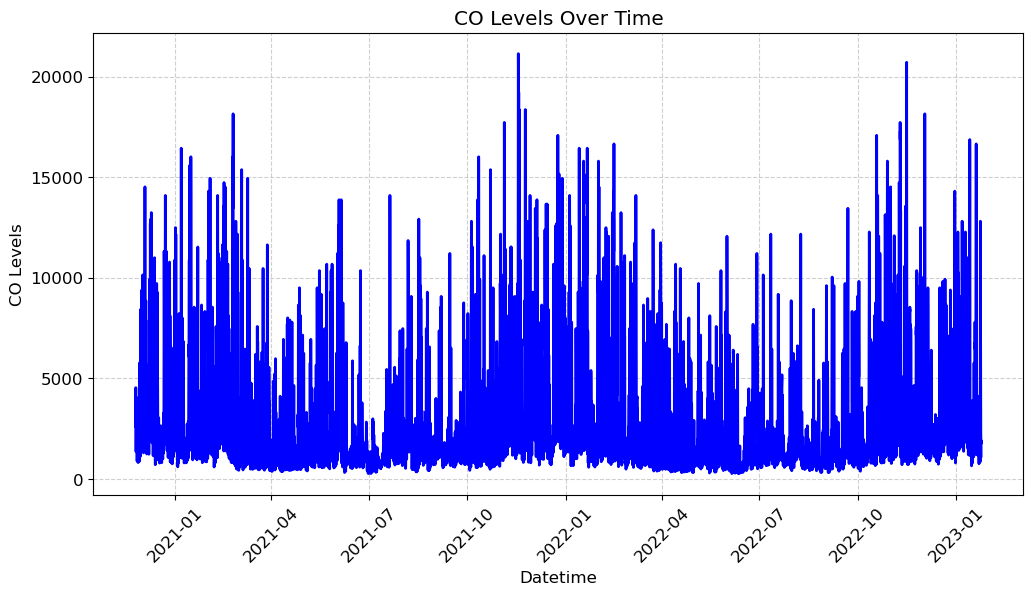

In [9]:

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_CO2['datetime'], df_CO2['co'], linestyle='-', marker='', color='b', linewidth=2)

# Formatting
plt.xlabel('Datetime')
plt.ylabel('CO Levels')
plt.title('CO Levels Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


## Train/test split for temporal data
<p>To evaluate the model’s ability to generalize, we will divide the data into training and testing subsets.</p>

<p>We will split the data as follows:</p>
<ul>
<li>We have total 18,776 data points.</li>
<li>We will use the fist 3,755 data points corresponding to the first 20% as training data - And the remaining 80% data points as test data.</li>

In [10]:
df_CO2.shape

(18776, 2)

In [11]:
n_train = 3755
train_df = df_CO2[:3755]
test_df = df_CO2[3755:]

## POSIX time feature
#### In this slice of the data, we just have a single feature: the date time feature.

#### We need to encode this feature if we want to build machine learning models.

#### A common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (this is beginning of Unix time).

#### Let’s start with encoding this feature as a single integer representing this POSIX time.

In [12]:

df_CO2 = df_CO2.set_index('datetime')
df_CO2.head()

,co
datetime,
2020-11-25 01:00:00,2616.88
2020-11-25 02:00:00,3631.59
2020-11-25 03:00:00,4539.49
2020-11-25 04:00:00,4539.49
2020-11-25 05:00:00,4379.27


In [13]:
X = (
    df_CO2.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
)  # convert to POSIX time by dividing by 10**9
y = df_CO2['co'].values

In [14]:
# Ensure y_train and y_test contain only numerical CO values
y_train = train_df["co"].values
y_test = test_df["co"].values

# Convert datetime index to POSIX time (Unix timestamp)
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9


<p>Our prediction task is a regression task.</p>

<p>Let’s try random forest regression with just this feature.</p>

<p>We’ll be trying out many different features. So we’ll be using the function below which:</p>
<ul>
<li>Splits the data</li>

<li>Trains the given regressor model on the training data</li>

<li>Shows train and test scores</li>

<li>Plots the predictions on the train and test data</li></ul>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer

# Code credit: Adapted from 
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/

xticks = pd.date_range(start=df_CO2.index.min(), end=df_CO2.index.max(), freq="D")

def eval_on_features(features, target, regressor, n_train=3755, sales_data=False, 
                     ylabel='CO2', 
                     feat_names="Default", 
                     impute=True):
    """
    Evaluate a regression model on a given set of features and target.

    This function splits the data into training and test sets, fits the 
    regression model to the training data, and then evaluates and plots 
    the performance of the model on both the training and test datasets.
    """

    # Split the features and target data into training and test sets
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    if impute:
        simp = SimpleImputer()
        X_train = simp.fit_transform(X_train)
        X_test = simp.transform(X_test)
    
    # Fit the model on the training data
    regressor.fit(X_train, y_train)

    # Print R^2 scores for training and test datasets
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

    # Predict target variable for both training and test datasets
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)

    # Plotting
    plt.figure(figsize=(10, 3))

    # Fix tick mismatch issue
    if not sales_data:
        tick_step = max(1, len(features) // 10)  # Set step size for readability
        tick_positions = np.arange(0, len(features), tick_step)  # Select positions
        tick_labels = xticks[:len(tick_positions)].strftime("%a %m-%d")  # Ensure labels match positions
        
        # Ensure we don't mismatch tick counts
        if len(tick_positions) > len(tick_labels):
            tick_positions = tick_positions[:len(tick_labels)]
        elif len(tick_labels) > len(tick_positions):
            tick_labels = tick_labels[:len(tick_positions)]

        plt.xticks(tick_positions, tick_labels, rotation=90, ha="left")

    # Plot training and test data, along with predictions
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="test")
    plt.plot(range(n_train), y_pred_train, "--", label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, "--", label="prediction test")

    # Set plot title, labels, and legend
    title = regressor.__class__.__name__ + "\n Features= " + feat_names
    plt.title(title)
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.show()


## Baseline: RandomForest Regressor

Train-set R^2: 0.99
Test-set R^2: -0.60


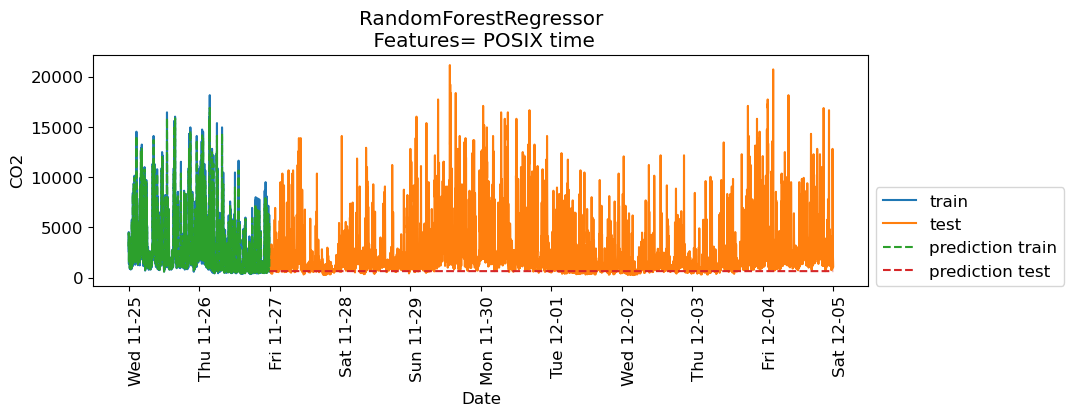

In [32]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor, feat_names="POSIX time")

As expected, regression performs poorly, Tree-based models cannot extrapolate to feature ranges outside the training data. Let's perform some feature engineering.


In [34]:
df_CO2.index

DatetimeIndex(['2020-11-25 01:00:00', '2020-11-25 02:00:00',
               '2020-11-25 03:00:00', '2020-11-25 04:00:00',
               '2020-11-25 05:00:00', '2020-11-25 06:00:00',
               '2020-11-25 07:00:00', '2020-11-25 08:00:00',
               '2020-11-25 09:00:00', '2020-11-25 10:00:00',
               ...
               '2023-01-23 23:00:00', '2023-01-24 00:00:00',
               '2023-01-24 01:00:00', '2023-01-24 02:00:00',
               '2023-01-24 03:00:00', '2023-01-24 04:00:00',
               '2023-01-24 05:00:00', '2023-01-24 06:00:00',
               '2023-01-24 07:00:00', '2023-01-24 08:00:00'],
              dtype='datetime64[ns]', name='datetime', length=18776, freq=None)

In [35]:
df_CO2.index.month_name()

Index(['November', 'November', 'November', 'November', 'November', 'November',
       'November', 'November', 'November', 'November',
       ...
       'January', 'January', 'January', 'January', 'January', 'January',
       'January', 'January', 'January', 'January'],
      dtype='object', name='datetime', length=18776)

In [36]:
df_CO2.index.dayofweek

Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       ...
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype='int32', name='datetime', length=18776)

In [37]:
df_CO2.index.day_name()

Index(['Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday',
       'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday',
       ...
       'Monday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object', name='datetime', length=18776)

In [38]:
df_CO2.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       23,  0,  1,  2,  3,  4,  5,  6,  7,  8],
      dtype='int32', name='datetime', length=18776)

In [44]:
X_hour = df_CO2.index.hour.values.reshape(-1, 1)
X_hour[:10]

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]], dtype=int32)

Train-set R^2: 0.19
Test-set R^2: 0.11


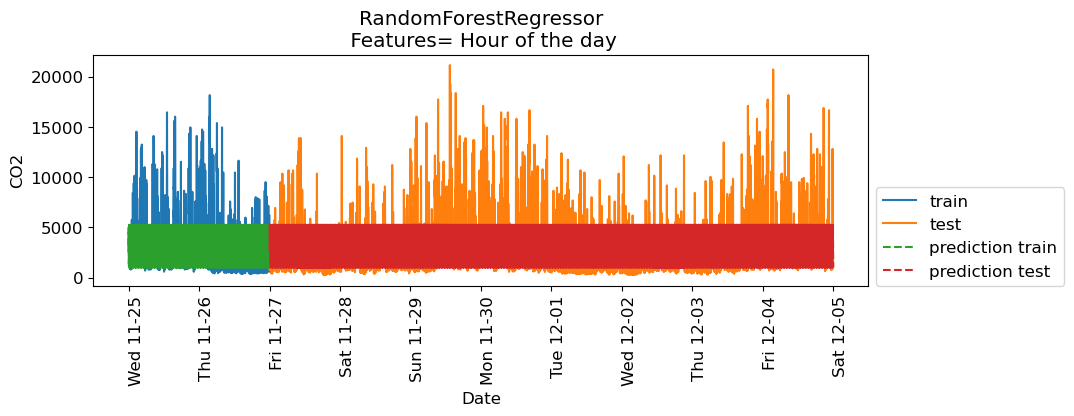

In [45]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor, feat_names = "Hour of the day")

Train-set R^2: 0.24
Test-set R^2: 0.11


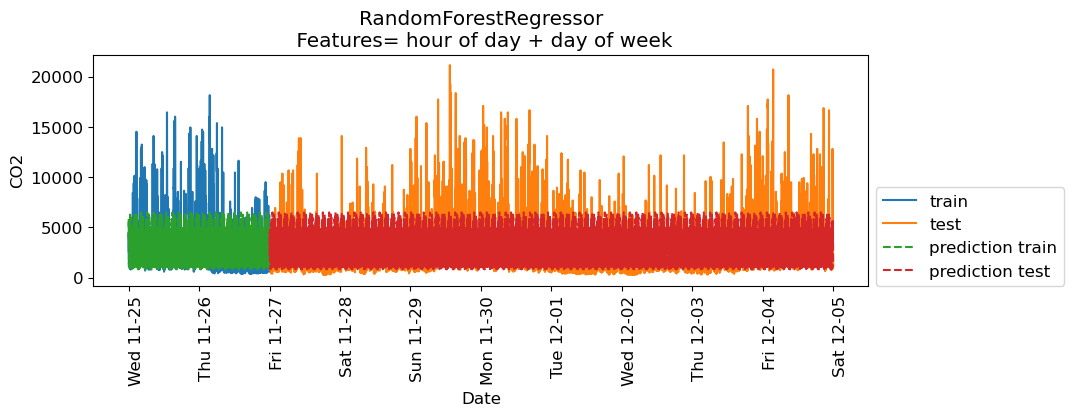

In [47]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
X_hour_week = np.hstack(
    [
        df_CO2.index.dayofweek.values.reshape(-1, 1),
        df_CO2.index.hour.values.reshape(-1, 1),
    ]
)
eval_on_features(X_hour_week, y, regressor, feat_names = "hour of day + day of week")

Train-set R^2: 0.02
Test-set R^2: -0.02


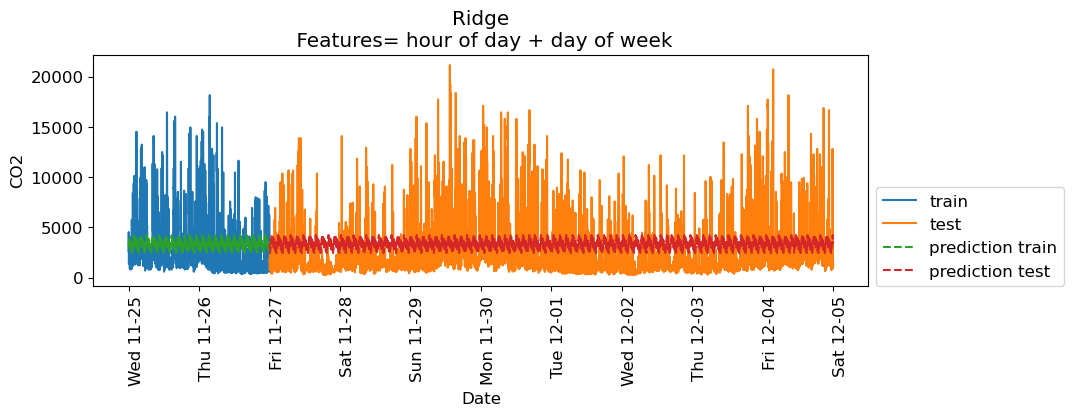

In [48]:
from sklearn.linear_model import Ridge

lr = Ridge();
eval_on_features(X_hour_week, y, lr, feat_names = "hour of day + day of week")

In [50]:
df1 = pd.DataFrame(df_CO2)

df1

,co
datetime,
2020-11-25 01:00:00,2616.88
2020-11-25 02:00:00,3631.59
2020-11-25 03:00:00,4539.49
2020-11-25 04:00:00,4539.49
2020-11-25 05:00:00,4379.27
...,...
2023-01-24 04:00:00,1762.39
2023-01-24 05:00:00,1735.69
2023-01-24 06:00:00,1922.61


In [51]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [53]:
emissions_lag5 = create_lag_df(df1, 5, ['co'] )
emissions_lag5.head()

,co,co-1,co-2,co-3,co-4,co-5
datetime,,,,,,
2020-11-25 01:00:00,2616.88,NaN,NaN,NaN,NaN,NaN
2020-11-25 02:00:00,3631.59,2616.88,NaN,NaN,NaN,NaN
2020-11-25 03:00:00,4539.49,3631.59,2616.88,NaN,NaN,NaN
2020-11-25 04:00:00,4539.49,4539.49,3631.59,2616.88,NaN,NaN
2020-11-25 05:00:00,4379.27,4539.49,4539.49,3631.59,2616.88,NaN


In [54]:
X_lag_features = emissions_lag5.drop(columns = ['co']).to_numpy()
X_lag_features

array([[    nan,     nan,     nan,     nan,     nan],
       [2616.88,     nan,     nan,     nan,     nan],
       [3631.59, 2616.88,     nan,     nan,     nan],
       ...,
       [1735.69, 1762.39, 2136.23, 2162.93, 2269.75],
       [1922.61, 1735.69, 1762.39, 2136.23, 2162.93],
       [1361.85, 1922.61, 1735.69, 1762.39, 2136.23]])

Train-set R^2: 0.90
Test-set R^2: 0.92


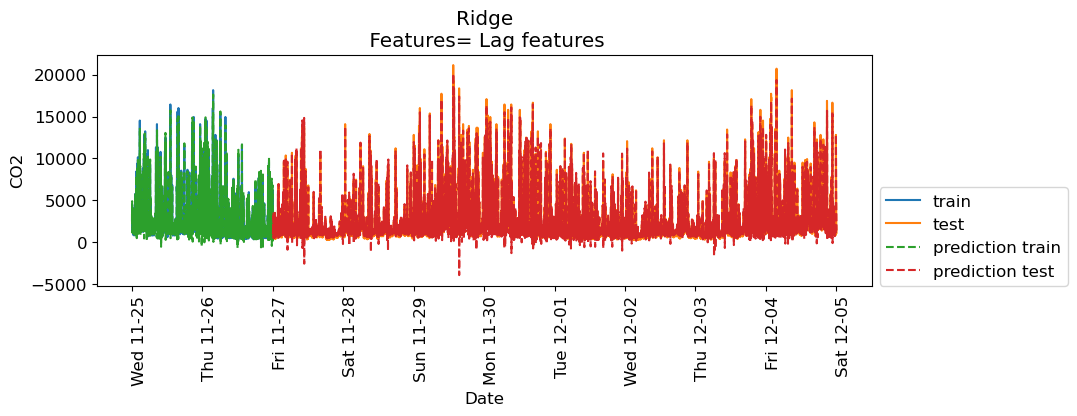

In [55]:
lr = Ridge()
eval_on_features(X_lag_features, y, lr, feat_names="Lag features", impute="yes")